In [1]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer

c:\Users\vivek\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_train = pd.read_csv(r'D:\AG_News\ML-Lab-AGNews\train\train.csv',delimiter=',')
data_train.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [3]:
data_test = pd.read_csv(r'D:\AG_News\ML-Lab-AGNews\test\test.csv',delimiter=',')
data_test.head()

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


In [4]:
data_train["Title"]       = data_train["Title"].fillna("").astype(str)
data_train["Description"] = data_train["Description"].fillna("").astype(str)

In [5]:
data_train["text"] = data_train["Title"] + " " + data_train["Description"]
data_train["text"] = data_train["text"].str.replace(r"\s+", " ", regex=True).str.strip()
data_train["label"] = data_train["Class Index"]
data_train = data_train[['text', 'label']]
data_train.head()

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,3
1,Carlyle Looks Toward Commercial Aerospace (Reu...,3
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,3
3,Iraq Halts Oil Exports from Main Southern Pipe...,3
4,"Oil prices soar to all-time record, posing new...",3


In [6]:
data_train["label"] = data_train["label"] - 1  

In [7]:
num_classes = data_train['label'].nunique()  
records_per_class = 15000 // num_classes  

data_train_balanced = data_train.groupby('label', group_keys=False).apply(lambda x: x.sample(n=records_per_class, random_state=42))

data_train_balanced = data_train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(data_train_balanced.shape) 


(15000, 2)


C:\Users\vivek\AppData\Local\Temp\ipykernel_22876\378019473.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_train_balanced = data_train.groupby('label', group_keys=False).apply(lambda x: x.sample(n=records_per_class, random_state=42))


In [8]:
import re 
def remove_punctuations(text):
     text=re.sub(r'[\\-]',' ',text)
     text=re.sub(r'[,.?;:\'(){}!|0-9]','',text)
     return text

data_train_balanced['text']=data_train_balanced['text'].apply(remove_punctuations)

In [9]:
from nltk.corpus import stopwords

stopw=stopwords.words('english')
def remove_stopwords(text):
    clean_text=[]
    for word in text.split(' '):
        if word not in stopw:
            clean_text.append(word)
    return ' '.join(clean_text)


data_train_balanced['text']=data_train_balanced['text'].apply(remove_stopwords)


In [10]:
print(data_train_balanced['label'].value_counts())


label
3    3750
1    3750
0    3750
2    3750
Name: count, dtype: int64


In [11]:
data_train_balanced.head()

,text,label
0,Microsoft revamps plans Longhorn update To get...,3
1,NFL Wrap McNabb Leads Eagles th Straight East ...,1
2,Microsoft plays SP security glitches Glitches ...,3
3,Iran nuclear talks Europe Iranian European off...,0
4,Costa Davidenko Bounced Bucharest BUCHAREST Re...,1


labels = {0:'World',1:'Sports',2:'Business',3:'Science'}

In [12]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [13]:
encoded_data = tokenizer.batch_encode_plus(
    data_train_balanced["text"].tolist(),  # List of texts
    add_special_tokens=True,      # Add [CLS] and [SEP]
    max_length=128,               # Truncate/pad to 128 tokens
    padding='max_length',         # Pad to max length
    truncation=True,              # Truncate long sequences
    return_tensors="pt",          # Return PyTorch tensors
    return_attention_mask=True     # Include attention mask
)

# Convert tokenized output into tensors
input_ids = encoded_data["input_ids"]
attention_masks = encoded_data["attention_mask"]
labels = torch.tensor(data_train_balanced["label"].values)
labels = labels.long()

# Print shape of encoded data
print(f"Input IDs shape: {input_ids.shape}")
print(f"Attention Mask shape: {attention_masks.shape}")
print(f"Labels shape: {labels.shape}")


Input IDs shape: torch.Size([15000, 128])
Attention Mask shape: torch.Size([15000, 128])
Labels shape: torch.Size([15000])


In [14]:
import torch
torch.cuda.empty_cache()


In [15]:
print("\nPreprocessed DataFrame:")
data_train_balanced.head()


Preprocessed DataFrame:


,text,label
0,Microsoft revamps plans Longhorn update To get...,3
1,NFL Wrap McNabb Leads Eagles th Straight East ...,1
2,Microsoft plays SP security glitches Glitches ...,3
3,Iran nuclear talks Europe Iranian European off...,0
4,Costa Davidenko Bounced Bucharest BUCHAREST Re...,1


In [16]:
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from transformers import BertForSequenceClassification, AdamW
from torch.cuda.amp import autocast, GradScaler  # For mixed precision training

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)
model.to(device)

# Create dataset & dataloader
train_dataset = TensorDataset(input_ids, attention_masks, labels)
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=16)  # Adjust batch size if needed

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\vivek\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
scaler = GradScaler()

C:\Users\vivek\AppData\Local\Temp\ipykernel_22876\2677878292.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [18]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print(f"CUDA is available! Using {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is NOT available. Using CPU.")


CUDA is available! Using NVIDIA GeForce RTX 3050 Laptop GPU


In [19]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [20]:
from torch.nn import functional as F

epochs = 3

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    model.train()

    total_loss = 0
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_masks, labels = batch

        optimizer.zero_grad()

        with autocast():
            outputs = model(input_ids, attention_mask=attention_masks)
            loss = torch.nn.functional.cross_entropy(outputs.logits, labels)  

        scaler.scale(loss).backward()

        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Average loss: {avg_loss:.4f}")

print("Training complete! 🎯")



C:\Users\vivek\AppData\Local\Temp\ipykernel_22876\3458036629.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/3
Average loss: 0.3461
Epoch 2/3
Average loss: 0.1941
Epoch 3/3
Average loss: 0.1225
Training complete! 🎯


In [21]:
import torch

# Define the path to save the model
MODEL_PATH = "trained_model.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), MODEL_PATH)

print(f"Model saved successfully at {MODEL_PATH} ✅")


Model saved successfully at trained_model.pth ✅


In [22]:

data_test = pd.read_csv(r'D:\AG_News\ML-Lab-AGNews\test\test.csv',delimiter=',')

data_test["text"] = data_test["Title"] + " " + data_test["Description"]
data_test["text"] = data_test["text"].str.replace(r"\s+", " ", regex=True).str.strip()

# Assign 'Class Index' to 'label'
data_test["label"] = data_test["Class Index"]

# Keep only 'text' and 'label' columns
data_test = data_test[["text", "label"]]

# Display the first few rows
data_test.head()



,text,label
0,Fears for T N pension after talks Unions repre...,3
1,The Race is On: Second Private Team Sets Launc...,4
2,Ky. Company Wins Grant to Study Peptides (AP) ...,4
3,Prediction Unit Helps Forecast Wildfires (AP) ...,4
4,Calif. Aims to Limit Farm-Related Smog (AP) AP...,4


In [23]:
num_classes = data_test['label'].nunique()  
records_per_class = 4000 // num_classes  

data_test_balanced = data_test.groupby('label', group_keys=False).apply(lambda x: x.sample(n=records_per_class, random_state=42))

data_test_balanced = data_test_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

data_test_balanced["label"]=data_test_balanced["label"]-1
print(data_test_balanced.shape) 

(4000, 2)


C:\Users\vivek\AppData\Local\Temp\ipykernel_22876\3844498812.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_test_balanced = data_test.groupby('label', group_keys=False).apply(lambda x: x.sample(n=records_per_class, random_state=42))


In [24]:
import re 
def remove_punctuations(text):
     text=re.sub(r'[\\-]',' ',text)
     text=re.sub(r'[,.?;:\'(){}!|0-9]','',text)
     return text

data_test_balanced['text']=data_test_balanced['text'].apply(remove_punctuations)

In [25]:
from nltk.corpus import stopwords

stopw=stopwords.words('english')
def remove_stopwords(text):
    clean_text=[]
    for word in text.split(' '):
        if word not in stopw:
            clean_text.append(word)
    return ' '.join(clean_text)


data_test_balanced['text']=data_test_balanced['text'].apply(remove_stopwords)


In [26]:
test_encoded_data = tokenizer.batch_encode_plus(
    data_test_balanced["text"].tolist(),  # List of texts
    add_special_tokens=True,      # Add [CLS] and [SEP]
    max_length=128,               # Truncate/pad to 128 tokens
    padding='max_length',         # Pad to max length
    truncation=True,              # Truncate long sequences
    return_tensors="pt",          # Return PyTorch tensors
    return_attention_mask=True     # Include attention mask
)

# Convert tokenized output into tensors
t_input_ids = test_encoded_data["input_ids"]
t_attention_masks = test_encoded_data["attention_mask"]

t_labels = torch.tensor(data_test_balanced["label"].values)
t_labels = t_labels.long()

# Print shape of encoded data
print(f"Input IDs shape: {t_input_ids.shape}")
print(f"Attention Mask shape: {t_attention_masks.shape}")
print(f"Labels shape: {t_labels.shape}")

Input IDs shape: torch.Size([4000, 128])
Attention Mask shape: torch.Size([4000, 128])
Labels shape: torch.Size([4000])


In [27]:
test_dataset = TensorDataset(t_input_ids, t_attention_masks, t_labels)
test_dataloader = DataLoader(test_dataset, sampler=RandomSampler(test_dataset), batch_size=32) 

In [28]:
import torch
torch.cuda.empty_cache()


In [29]:
import torch
import numpy as np
from sklearn.metrics import classification_report

# Force execution on CPU
device = torch.device("cpu")
torch.cuda.is_available = lambda: False  # Disable CUDA detection
model.to(device)
model.eval()  # Set model to evaluation mode

all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient calculation for inference
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)  # Move batch to CPU
        input_ids, attention_masks, labels = batch
        
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs.logits
        
        # Convert logits to predicted class labels
        preds = torch.argmax(logits, dim=1).numpy()
        all_preds.extend(preds)
        
        # Store true labels
        all_labels.extend(labels.numpy())

# Generate classification report
print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.97      0.86      0.91      1000
           1       0.95      0.99      0.97      1000
           2       0.86      0.89      0.88      1000
           3       0.87      0.91      0.89      1000

    accuracy                           0.91      4000
   macro avg       0.92      0.91      0.91      4000
weighted avg       0.92      0.91      0.91      4000



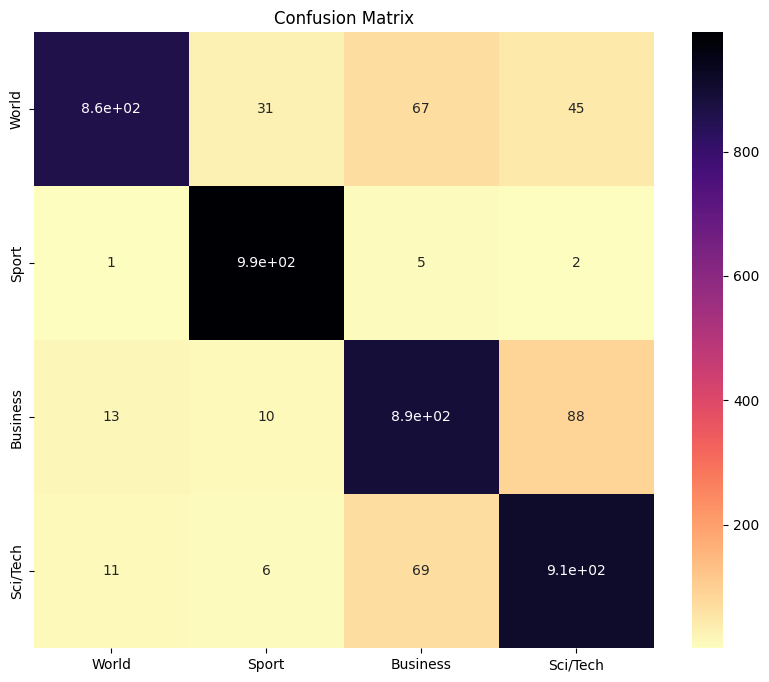

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix
plt.figure(figsize=(10,8))

# plot the heat map 
sns.heatmap(
    confusion_matrix(all_labels, all_preds),
    annot=True,
    xticklabels=['World','Sport','Business','Sci/Tech'],
    yticklabels=['World','Sport','Business','Sci/Tech'],
    cmap=plt.cm.magma_r
)
plt.title('Confusion Matrix')
plt.show()

In [31]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
